# Segmentation de formes nuageuses - prise en main des données



Ce notebook est dédié à la prise en main des données du projet intitulé "segmentation de formes nuageuses".
- rappel du contexte et de la problématique
- découverte des données disponible
- analyse des données
- premier nettoyage des données

# I.Contexte et données du problème

## I.1 Contexte

Ce projet a pour objet l'étude de formes nuageuses sur des images satellites. La formation des nuages reste en effet un phénomène toujours mal compris, et qui joue pourtant un rôle important dans les modèles climatiques. A l'heure actuelle, cette étude est toujours effectuée par un "oeil humain", c'est-à-dire que ce sont des chercheurs qui repèrent la présence d'une ou plusieurs formes nuageuses sur une image satellite.
L'objectif de ce projet est double. Il s'agit d'une part de proposer un algorithme de classification permettant de prédire la présence de formes nuageuses sur des images satellites, et d'autre part, pour chaque forme présente, de prédire la zone de l'image où elle se trouve.

## I.2 Données du projet

Pour mener à bien ce projet, un ensemble de données et fichiers nous a été fourni. Il est composé de:

* 9244 images jpeg (réparties entre 5546 images d'entrainement et 3698 images de test)
* 2 fichiers csv intitulés respectivement "train.csv" et "sample_submission.csv".


Nous allons dans un premier temps analyser le contenu de ces fichiers csv.

In [1]:
import pandas as pd
df_train = pd.read_csv('train.csv')
df_sample = pd.read_csv('sample_submission.csv')

In [2]:
print('dimensions df_train:', df_train.shape)
print('dimensions df_sample:', df_sample.shape)


dimensions df_train: (22184, 2)
dimensions df_sample: (14792, 2)


In [3]:
df_train.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [4]:
df_sample.head()

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,1 1
1,002f507.jpg_Flower,1 1
2,002f507.jpg_Gravel,1 1
3,002f507.jpg_Sugar,1 1
4,0035ae9.jpg_Fish,1 1


Ce premier affichage nous donne déjà quelques informations.
* chacun des fichiers csv est associé à l'un des ensembles d'images (train ou test)
* comme indiqué dans l'énoncé Kaggle, il y a 4 formes de nuages (Fish, Gravel, Flower, Sugar) et les fichiers csv contiennent chacun 4 lignes (une par forme de nuage) pour chaque image du dataset correspondant
* ainsi, le dataset d'entrainement "train_images" contient 5546 images, et donc le fichier csv associé, nommé train.csv, contient 4 * 5546 = 22184 lignes
* de même pour le dataset de test "test_images" avec 3698 images pour 4 * 3698 = 14792 lignes dans le fichier sample_submission.csv associé

Penchons nous maintenant sur les colonnes des fichiers csv: il n'y en a que 2, nommées Image_Label, et EncodedPixels: regardons la colonne Image_Label:

* la colonne Image_label contient un nom qui est la concaténation du nom de l'image (par exemple '0011165.jpg')du caractère '_' et du nom d'une des 4 formes: 'Fish', 'Flower', 'Gravel' ou 'Sugar'.
* Ainsi, pour l'image '0011165.jpg' nous avons 4 lignes dont les valeurs de Image_Label associées sont '0011165.jpg_Fish', '0011165.jpg_Flower', '0011165.jpg_Sugar', et '0011165.jpg_Gravel'. La valeur prise par cette colonne caractérise donc le couple (image, forme).

De son côté, la colonne EncodedPixels du fichier "train.csv" peut contenir 2 choses: 
* soit le couple (Image, Forme) est "valide", dans le sens où la forme considérée est bien présente sur l'image considérée. Dans ce cas, EncodedPixels contient la liste des pixels où l'image se trouve. Cet ensemble de pixels peut couvrir une ou plusieurs zones, tous les pixels forment une seule ligne.
* soirt le couple (Image, Forme) est non valide, ce qui signifie que la forme considérée n'est pas présente, et dans ce cas, la valeur EncodedPixels est un NaN.

Concernant le fichier "sample_submission.csv", la colonne EncodedPixels ne contient que la valeur '1 1' et l'objectif de ce projet sera d'entraîner un modèle qui permettra justement de prédire la valeur de cette colonne (ie présence de formes et localisation sur l'image).



In [5]:
print(df_sample['EncodedPixels'].value_counts())

1 1    14792
Name: EncodedPixels, dtype: int64


## I.3 Première visualisation

Afin de mieux appréhender la forme des informations fournies dans le dataset, nous allons dans un premier temps visualiser une première image, ainsi que les formes  nuageuses associées.

### Première visualisation d'une image

Prenons la première image '0011165.jpg' de l'ensemble d'entraînement.
Commençons par afficher l'image seule:

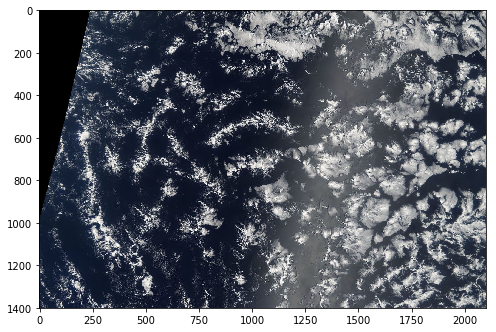

dimension de l image: (1400, 2100, 3)


In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,6))
img_color = cv2.imread("train_images/0011165.jpg")
img_color= cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
plt.imshow(img_color)
#plt.grid(False)
plt.show()

print('dimension de l image:', img_color.shape)


Cette image est de taille 1400 x 2100.

###  Première visualisation de formes nuageuses.

Nous allons à présent afficher les zones des formes nuageuses, correspondant donc aux pixels renseignés dans la colonne "EncodedPixels".
Nous avons vu que lorsque la forme nuageuse en question est présente, la colonne EncodedPixels associée au couple (ImageId,Forme) contient un string, qui semble être une liste de nombres entiers. Ces informations doivent nous permettrent à priori de tracer une ou plusieurs zones sur l'image.

#### Interprétation de l'encodage

Regardons les premiers éléments de la liste de nombres de la colonne EncodedPixels. Pour l'Image_Label '0011165.jpg_Fish' nous avons:

In [8]:
print(df_train.iloc[0,1][0:98])

264918 937 266318 937 267718 937 269118 937 270518 937 271918 937 273318 937 274718 937 276118 937


On remarque 2 choses:
* les nombres d'indices pairs ne varient pas, ils sont tous égaux à 937.
* les nombres d'indice impairs semblent constituer une suite arithmétique de raison 1400, c'est-à-dire la hauteur totale de l'image.

On peut supposer la règle d'encodage suivant: chaque couple de coordonnées (A,B) de la liste d'encodage correspond à un segment vertical (ie dans le sens de la hauteur) de pixels, de longueur B et dont le point de départ (en haut)  a pour coordonnées (x(A), y(A)) , x(A) représentant sa coordonnée selon la hauteur et y(A) sa coordonnée selon largeur -,avec:

A = 1400*y + x 

x est donc le quotient entier de la division de A par la largeur (2100 ici), et y le reste de cette division.
Prenons l'exemple des 2 premiers nombres de notre liste de pixels encodés:

A1 = 264918 ; B1 = 937

On remarque que:

264918 = 189 * 1400 + 318

Ce couple correspond donc au segment horizontal allant du point P1 de coordonnées (318,189) au point Q1 (1255,189). L'encodage a donc permis de résumer les coordonnées de 937 points du segment P1Q1 (donc 1874 données) à seulement un seul couple de données. 

Remarque: si les dimensions des images sont différentes alors on la règle d'encodage devrait elle aussi varier, puisque nous avons vu qu'elle dépend de la hauteur de l'image. Néanmoins, nous vérifierons plus tard que toutes les images ont la même dimension.

Nous pouvons désormais définir une fonction qui prendra en argument la chaîne de nombre (au format string) de la colonne EncodedPixels, et qui renverra une image noir et blanc, de même dimension que l'image analysée (ici 1400 x 2100), avec pour chaque pixel la valeur 0, sauf dans les zones définissant la ou les formes présentent, qui seront mises à 1.

In [9]:
def pixels_to_img(pixel_string, hauteur, largeur ):
    # dans le doute on passe en argument les dimensions de l'image à créer
    rows, cols = hauteur, largeur  
    # en cas d'absence de forme, on renvoit uniquement un tableau de 0
    if str(pixel_string) == 'nan':
        return np.zeros((hauteur, largeur))
    else:
        # etape 1 on redécoupe le string en array de couples correspondant aux A et B ci dessus
        segment_list = np.array([int(num_string) for num_string in pixel_string.split(' ')]).reshape(-1,2)
        # etape 2: on initialise un vecteur de dimension totale (hauteur x largeur)
        img = np.zeros((rows,cols))
        # on boucle sur les couples (A,B) de la segment_list
        for a, b in segment_list:
            # on recalcule les coordonnées du premier point P du segment
            y = a // hauteur
            x = a % hauteur
            # on met à 255 la valeur de tous les pixels du segment correspondant
            for j in range(b):
                if (0<=(x+j) <hauteur) and (0<=y < largeur): 
                    img[x+j,y] = 255
        return img
    

Appliquons à présent la fonction pixels_to_img à la liste de pixels encodés correspondant à l'image 00011165.jpg et à la forme 'Fish'.

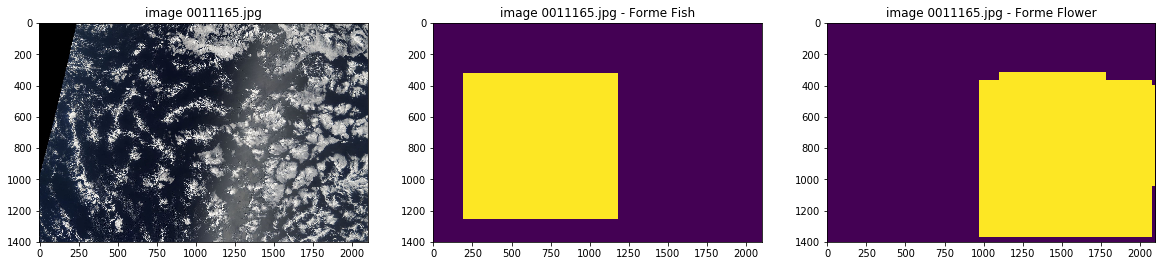

In [10]:
pixel_string = df_train.iloc[0,1]
img_fish = pixels_to_img(pixel_string, 1400,2100)
pixel_string2 = df_train.iloc[1,1]
img_flower = pixels_to_img(pixel_string2, 1400,2100)
plt.figure(figsize = (20,8))
plt.subplot(131)
img_color_= cv2.imread("train_images/0011165.jpg",cv2.COLOR_BGR2RGB)
img_color2=cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
plt.imshow(img_color)
plt.title('image 0011165.jpg')
plt.subplot(132)
plt.imshow(img_fish)
plt.title('image 0011165.jpg - Forme Fish')
plt.subplot(133)
plt.imshow(img_flower)
plt.title('image 0011165.jpg - Forme Flower')
plt.show()


Nous constatons déjà sur cette image que les zones associées à chacune des formes peuvent se superposer. La formes des nuages dans les 2 zones identifiées semblent bien cohérentes avec leur label.

#### Première analyse des couleurs de l'image

Nous pouvons également regarder comment se répartissent les couleurs des pixels de notre image. Pour cela nous allons projeter les 3 niveaux de couleurs pour chaque pixel sous la forme d'un nuage de points en 3 dimensions.

In [11]:
img= cv2.imread("train_images/0011165.jpg",cv2.IMREAD_COLOR)
img_color= cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
# nous initialisons un vecteur pour chaque couleur
col1 = []
col2 = []
col3 = []
# récupération des 3 niveaux de couleur
col1.append(img[:,:,0])
col2.append(img[:,:,1])
col3.append(img[:,:,2])

                         

In [12]:
from mpl_toolkits.mplot3d import axes3d

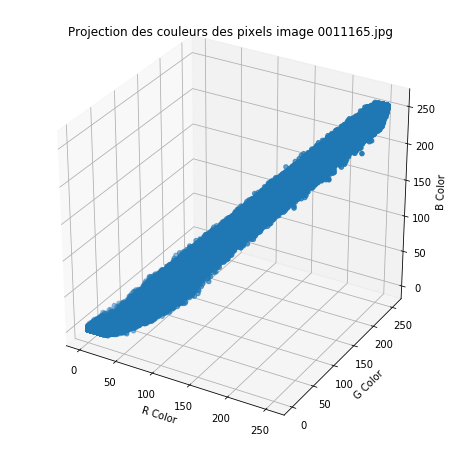

In [12]:
# nous traçons le nuage de points 3D correspondant
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(col1, col2, col3)
ax.set_title('Projection des couleurs des pixels image 0011165.jpg')
ax.set_xlabel('R Color')
ax.set_ylabel('G Color')
ax.set_zlabel('B Color')
plt.show()

Ce graphe semble indiquer que l'ensemble des pixels semblent se situer à proximité du plan "couleur 1 = couleur 2 = couleur 3", autrement dit du noir et blanc. Cette conclusion est tout à fait cohérente avec la visualisation que nous avons fait de l'image. Cela semble indiquer que nous pourrions nous limiter à une description en noir et blanc des images. Nous vérifierons tout de même ce résultat sur un scope plus large (couleurs moyennes et écart type pour la totalité des images du dataset d'entrainement).

#  Etude statistique

Nous allons à présent mener quelques études statistiques sommaires, d'abord sur les labels de forme,puis sur les images, et enfin sur les dimensions des formes, elles-mêmes.

# II Etude statistique des labels de forme

Dans cette partie nous étudions les données du fichier d'entrainement, train.csv, en nous concentrant sur les labels de forme.

## II.1 Premières statistiques descriptives

Pour commencer, nous voudrions savoir pour chaque image et pour chacune des forme si la forme est présente ou non sur l'image. Nous allons commencer par regarder le nombre de fois où chaque forme apparait. La première étape va consister à séparer en deux l'information contenue dans la colonne "Image_Label". Nous allons créer une colonne ImageId contenant le nom de l'image, et une colonne Label, contenant le nom de la forme.

In [13]:
split = df_train["Image_Label"].str.split("_", n = 1, expand = True)
df_train['ImageId'] = split[0]
df_train['Label'] = split[1]
df_train.head()

,Image_Label,EncodedPixels,ImageId,Label
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower
2,0011165.jpg_Gravel,NaN,0011165.jpg,Gravel
3,0011165.jpg_Sugar,NaN,0011165.jpg,Sugar
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish


A présent nous sommes en mesure de compter le nombre total de fois où chaque forme apparaît dans le jeu d'entrainement. Pour chaque forme (ie Label = forme), on doit compter le nombre de lignes pour lesquels EncodedPixels est renseigné.

In [14]:
nb_fish = df_train[df_train['Label'] == 'Fish'].EncodedPixels.count()
print('nombre d images contenant la forme Fish: ', nb_fish)
nb_flower = df_train[df_train['Label'] == 'Flower'].EncodedPixels.count()
print('nombre d images contenant la forme Flower: ', nb_flower)
nb_gravel = df_train[df_train['Label'] == 'Gravel'].EncodedPixels.count()
print('nombre d images contenant la forme Gravel: ', nb_gravel)
nb_sugar = df_train[df_train['Label'] == 'Sugar'].EncodedPixels.count()
print('nombre d images contenant la forme Sugar: ', nb_sugar)
print('nombre total d images : ', pd.DataFrame(df_train.groupby('ImageId')).shape[0])


nombre d images contenant la forme Fish:  2781
nombre d images contenant la forme Flower:  2365
nombre d images contenant la forme Gravel:  2939
nombre d images contenant la forme Sugar:  3751
nombre total d images :  5546


Nous constatons que chaque forme est présente sur un pourcentage d'images compris entre 42% (Flower) et 67,6% (Sugar).
Il peut aussi être intéressant de regarder combien de formes différentes contient chaque image.  

In [15]:
df_count = pd.DataFrame(df_train.groupby('ImageId').EncodedPixels.count())
df_count = df_count.rename({'EncodedPixels': 'nb_formes'}, axis = 1)

df_count.head()

,nb_formes
ImageId,
0011165.jpg,2
002be4f.jpg,3
0031ae9.jpg,3
0035239.jpg,2
003994e.jpg,3


On peut tout d'abord vérifier que toutes les images sont bizn toujours présentes.

In [16]:
print('nombre d images avec formes:', df_count.shape[0])

nombre d images avec formes: 5546


Ceci indique que chaque image contient au moins une forme (les images sans formes auraient du avoir été exclues du fait du count() sur la colonne EncodedPixels). Regardons à présent la distribution du nb de formes par image.

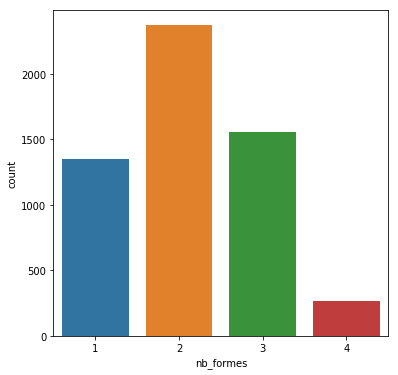

nombre moyen de formes par images: 2.134150739271547
nombre d images contenant les 4 formes:  266


In [17]:
import seaborn as sns
fig = plt.figure(figsize = (6,6))
sns.countplot(x ='nb_formes', data = df_count)
plt.show()

print('nombre moyen de formes par images:' , df_count.nb_formes.mean())
print('nombre d images contenant les 4 formes: ', df_count[df_count.nb_formes == 4].count()[0])

On confirme donc que chaque image contient au moins une forme. Le nombre de formes par images le plus fréquent est donc 2, en moyenne les images contiennes 2.134 formes chacune, et seulement 266 images contiennent les 4 formes.

## II.2 Matrice d'adjacence des labels de formes

Nous souhaitons à présent  étudier la matrice d'adjacence des différentes formes. Pour cela nous allons construire un DataFrame qui contiendra 5 colonnes:
* le nom de l'image
* la fonction indicatrice pour la forme 'Fish' (qui vaut donc 1 si Fish est présent sur l'image, 0 sinon)
* ...
* la fonction indicatrice pour l'image 'Sugar'
La cellule suivante permet de construire un nouveau dataframe à partir de df_train, nommé df_train_class, qui contient ces informations.

In [18]:
# on commence par créer les colonnes indicatrices pour les formes, par dichotomie.
df_corr =  pd.get_dummies(df_train, columns = ['Label'])
# on suppprime les lignes ne contenant pas de forme
df_corr = df_corr.dropna(how = 'any', axis = 0)
# on droppe les colonnes inutiles
df_corr = df_corr.drop(['Image_Label', 'EncodedPixels'], axis = 1)
# on regroupe par ImageId, et on prend le max pour chacun des labels
df_corr = df_corr.groupby('ImageId').max()
df_corr.head(5)

,Label_Fish,Label_Flower,Label_Gravel,Label_Sugar
ImageId,,,,
0011165.jpg,1,1,0,0
002be4f.jpg,1,1,0,1
0031ae9.jpg,1,1,0,1
0035239.jpg,0,1,1,0
003994e.jpg,1,0,1,1


Visualisons à présent une matrice de corrélation pour les différentes formes.

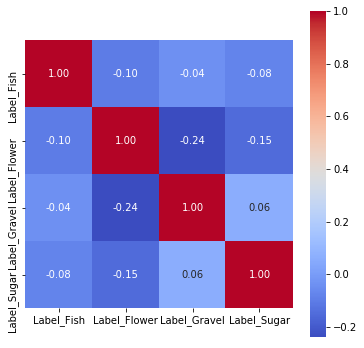

In [19]:
#corrs = np.corrcoef(corr_df.values.T)
import seaborn as sns
plt.figure(figsize=(6,6))
sns.heatmap(df_corr.corr(), cbar = True, annot=True, square = True,cmap = 'coolwarm', fmt = '.2f')
plt.show()
    


On constate une corrélation très légèrement négative entre la présence d'une des 4 formes et d'une des autres formes, ce qui ne nous donne pas beaucoup plus d'information. On note cependant que la corrélation la plus importante en valeur absolue est négative et est de -0.24 pour le couple Gravel-Flower. 
Nous confirmerons dans la section suivante que ces deux formes sont effectivement moins associées que les autres.


## II.3 Catégorisation exacte des labels de formes

On peut aller plus loin en regardant la composition des images monoformes et multiformes. Pour ces dernières nous avons les combinaisons suivantes:

* à deux formes: Fish/Flower, Fish/Gravel, Fish/Sugar, Flower/Gravel, Flower/Sugar, Gravel/Sugar
* à trois formes: Fish/Flower/Gravel, Fish/Flower/Sugar, Fish/Gravel/Sugar , Flower/Gravel/Sugar 
* ou les 4 formes

Nous allons définir une fonction qui n,ous renvoie la combinaison en fonction des valeurs des colonnes Label_Forme.

In [20]:
def get_exact_label(fish, flower, gravel, sugar):
    form_set = (fish, flower, gravel, sugar)
    if form_set == (1,0,0,0):
        return 'Fish'
    elif form_set == (0,1,0,0):
        return 'Flower'
    elif form_set == (0,0,1,0):
        return 'Gravel'        
    elif form_set == (0,0,0,1):
        return 'Sugar'
    elif form_set == (1,1,0,0):
        return 'Fish-Flower'
    elif form_set == (1,0,1,0):
        return 'Fish-Gravel'
    elif form_set == (1,0,0,1):
        return 'Fish-Sugar'
    elif form_set == (0,1,1,0):
        return 'Flower-Gravel'
    elif form_set == (0,1,0,1):
        return 'Flower-Sugar'
    elif form_set == (0,0,1,1):
        return 'Gravel-Sugar'
    elif form_set == (1,1,1,0):
        return 'Fish-Flower-Gravel'
    elif form_set == (1,1,0,1):
        return 'Fish-Flower-Sugar'
    elif form_set == (1,0,1,1):
        return 'Fish-Gravel-Sugar'    
    elif form_set == (0,1,1,1):
        return 'Flower-Gravel-Sugar' 
    elif form_set == (1,1,1,1):
        return 'Fish-Flower-Gravel-Sugar'
    else:
        return 'None'

Nous pouvons ajouter une colonne contenant ce Label multiple exact pour chaque image, et regarder la répartition.

In [21]:
df_corr['Multilabel'] = df_corr.apply(lambda row: get_exact_label(row[0], row[1], row[2], row[3]), axis = 1)
#df_corr.head(10)

Et donc tracer la répartition exacte des images par ensemble de formes.

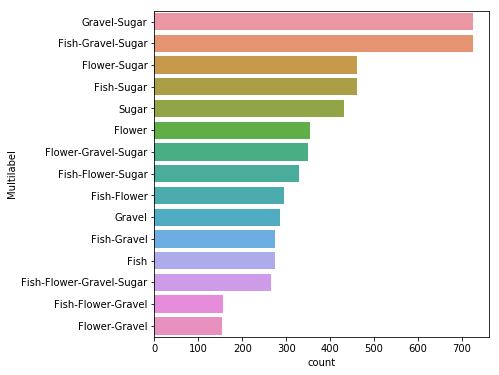

Gravel-Sugar                726
Fish-Gravel-Sugar           726
Flower-Sugar                462
Fish-Sugar                  462
Sugar                       432
Flower                      355
Flower-Gravel-Sugar         349
Fish-Flower-Sugar           328
Fish-Flower                 294
Gravel                      287
Fish-Gravel                 274
Fish                        274
Fish-Flower-Gravel-Sugar    266
Fish-Flower-Gravel          157
Flower-Gravel               154
Name: Multilabel, dtype: int64


In [22]:
fig = plt.figure(figsize = (6,6))
sns.countplot(y = df_corr['Multilabel'], order = df_corr['Multilabel'].value_counts().index )
plt.show()
print(df_corr['Multilabel'].value_counts())

On retrouve également le résultat de la section précédente: la combinaison Flower-Gravel est la combinaison la moins fréquente: ces deux formes sont rarement ensemble, d'où leur corrélation négative.


Nous sauvegardons cette matrice sous forme csv pour la suite.

In [21]:
df_corr.to_csv('df_corr.csv')

# III. Etude statistique des images

Après ce premier tour d'horizon des labels de forme, interessons-nous à présent aux images elles-mêmes. Une première vérification à effectuer concerne les dimensions des images elles-mêmes. Nous pouvons facilement vérifier qu'elles sont toutes identiques.

## III.1 Dimensions des images

Pour analyser les dimensions des images nous récupérons  les dimensions de toutes les images du jeu d'entrainement.


In [23]:
# definition des paths pour les images elles-mêmes
from glob import glob
TRAIN_PATH = 'train_images/'
TEST_PATH = 'test_images/'

# on définit une liste contenant les chemins des images
train_path = sorted(glob(TRAIN_PATH + '*.jpg'))


# nous allons récupérer l'ensemble des dimensions des images de l'ensemble d'entrainement
d_train = []
# on itère sur les images et on récupère leur dimension (nous nous contentons de grayscale car seules les dimensions en largeur hauteur nous intéressent)
for img in range(len(train_path)):    
        image = cv2.imread(train_path[img], cv2.IMREAD_GRAYSCALE)
        d_train.append([image.shape[0], image.shape[1]])



Nous pouvons aisément vérifier que la largeur et la hauteur sont les mêmes pour toutes les images (les maximums et minimums respectifs étant égaux). Aucune étape de changement d'échelle d'image ne devrait être nécessaire.

In [24]:
print('Hauteur max pour le train set:' ,max(np.array(d_train)[:,0]))
print('Hauteur min pour le train set:' ,min(np.array(d_train)[:,0]))
print('Largeur max pour le train set:' ,max(np.array(d_train)[:,1]))
print('Largeur min pour le train set:' ,min(np.array(d_train)[:,1]))


Hauteur max pour le train set: 1400
Hauteur min pour le train set: 1400
Largeur max pour le train set: 2100
Largeur min pour le train set: 2100


## III.2 Couleurs des Images

Un autre axe d'étude concernant les images est leur couleur. En effet, nous savons que chaque pixel est caractérisé par son code couleur, c'est-à-dire 3 entiers correspondant aux niveaux de bleu, de vert, et de rouge.
A première vue, les images, bien que colorées, sont assez proches du noir et blanc. Il est légitime de se demander si l'information codée sur 3 entiers ne pourrait pas se résumer à un seul.

Pour cela, nous allons:
* calculer la moyenne et l'écart type de chacun des 3 niveaux de couleur sur chacune des images
* afficher ces informations sous forme de nuage de points 3D pourt l'ensemble des images.

Commençons par définir la fonction qui va nous retourner le niveau moyen et l'écart type de chacune des 3 couleurs pour chaque image.

In [25]:
def get_std_avg_col_levels(image):
    """
    Fonction qui prend en argument une image et retourne la moyenne de chacun des niveaux de couleur ainsi que l'écart type
    """
    color_level = [0,0,0]
    color_std = [0,0,0]
    img= cv2.imread(image,cv2.IMREAD_COLOR)
    haut = img.shape[0]
    larg = img.shape[1]
    nb_col = img.shape[2]
    avg = cv2.meanStdDev(img)
    color_level = [avg[0][0],avg[0][1], avg[0][2]]
    color_std = [avg[1][0],avg[1][1], avg[1][2]]
    nameimage=image
    return color_level, color_std, nameimage

#get_avg_col_levels("0011165.jpg")


Maintenant, nous allons calculer ces niveau moyens et écarts type pour le dataset d'images d'entrainement, et afficher ces informations sous forme d'un nuage de points en 3 dimensions. Du fait du grand nombre de pixels (3M par imge) et d'image (plus de 5000) l'exécution de cette cellule peut prendre plusieurs minutes.

On crée un dataframe allant contenir ces niveau moyens et écarts type pour le dataset d'images d'entrainement

In [26]:
gd = pd.DataFrame(columns=["nameimage","col_level1", "col_level2", "col_level3", "col_std1", "col_std2", "col_std3"])

columns = list(gd)
data = []

for img in range(len(train_path)):
  col_levels, col_stds, nameimage = get_std_avg_col_levels(train_path[img])
  values = [nameimage, col_levels[0][0], col_levels[1][0], col_levels[2][0], col_stds[0][0], col_stds[1][0], col_stds[2][0]]
  zipped = zip(columns, values)
  a_dictionary = dict(zipped)
  #print(a_dictionary)
  data.append(a_dictionary)


In [27]:
df=gd

In [28]:
df = df.append(data, True)
df.head(5)

,nameimage,col_level1,col_level2,col_level3,col_std1,col_std2,col_std3
0,train_images/0011165.jpg,89.964270,79.563398,74.709553,56.442796,61.588358,63.529463
1,train_images/002be4f.jpg,90.023947,78.992696,73.988532,58.767171,64.354736,66.448791
2,train_images/0031ae9.jpg,76.586353,66.721373,62.210005,58.389281,61.172147,62.278045
3,train_images/0035239.jpg,63.133726,51.909152,46.890278,53.551423,55.557584,56.243256
4,train_images/003994e.jpg,81.247798,68.451784,64.574119,49.898003,52.125770,52.831733


### III.2.A Recherche d'images abérantes (outliers)

A partir des niveaux de couleurs moyens des images nous pouvons effectuer une première recherche d'outliers, en comparant les niveaux de couleurs moyens des images. 
Nous avons vu que les images 'grises' ont leurs 3 niveaux de couleur à peu près égaux, soit: col_level1 ~ col_level2 ~ col_level3.
Par conséquent, les outliers devraient avoir des niveaux de couleur assez différents entre eux.  Pour les identifier, nous allons calculer  (col_level1 - col_level2), (col_level1-col_level3), et (col_level2-col_level3). Pour les images "grises" ce sera à chaque fois proche de 0, mais pas pour les outliers.
On va donc créer une colonne associée dans le dataframme pour chacun de ces calculs.

In [29]:
df['cal1-2']=df['col_level1']-df['col_level2']
df['cal1-3']=df['col_level1']-df['col_level3']
df['cal2-3']=df['col_level2']-df['col_level3']

On trie le dataframe sur les valeurs du calcul n°1 cal1-2

In [30]:
df.sort_values(by=['cal1-2'], ascending=False)

,nameimage,col_level1,col_level2,col_level3,col_std1,col_std2,col_std3,cal1-2,cal1-3,cal2-3
4206,train_images/c26c635.jpg,138.268582,91.249132,33.976152,100.415100,77.199436,46.120408,47.019451,104.292430,57.272980
4984,train_images/e5f2f24.jpg,92.150758,66.741135,61.800643,59.411456,69.250628,69.064867,25.409623,30.350116,4.940493
5079,train_images/ea441e6.jpg,67.959032,46.504398,41.634023,49.474533,54.003905,54.680837,21.454634,26.325009,4.870374
3776,train_images/ad07d6c.jpg,75.208524,53.866848,48.121815,46.193409,50.905379,51.741717,21.341677,27.086710,5.745033
3311,train_images/96ce1b3.jpg,69.676601,49.525301,44.162300,50.699554,55.579367,56.289843,20.151300,25.514301,5.363001
...,...,...,...,...,...,...,...,...,...,...
4294,train_images/c647f73.jpg,104.624308,101.353921,98.463706,53.266265,55.779266,56.516992,3.270387,6.160602,2.890215
5275,train_images/f32724b.jpg,24.228464,22.003362,20.884956,55.039629,53.816943,53.344653,2.225101,3.343507,1.118406
815,train_images/24884e7.jpg,16.648680,15.145690,14.266382,44.988597,43.773080,42.640445,1.502989,2.382298,0.879309
1434,train_images/41f92e5.jpg,92.686383,92.978618,91.972450,56.614411,62.020174,63.928425,-0.292234,0.713933,1.006168


On observe pour certaines images des valeurs élevées pour les valeurs des calculs cal1-2, cal1-3 & cal2-3. En visualisant les 2 premières images c26c635.jpg et e5f2f24.jpg, on constate effectivement qu'elles sont très différentes des autres.

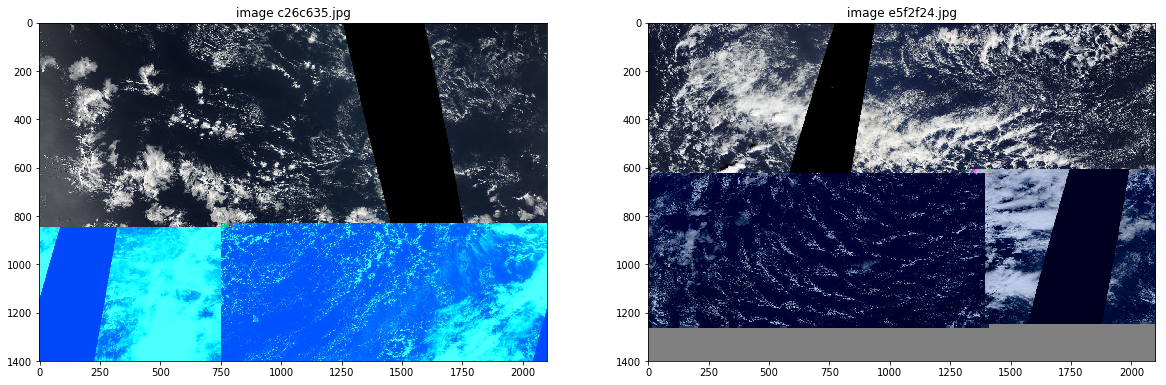

In [31]:

plt.figure(figsize = (20,8))
plt.subplot(121)
img_color= cv2.imread("train_images/c26c635.jpg",cv2.COLOR_BGR2RGB)
img_color1=cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
img_color_= cv2.imread("train_images/e5f2f24.jpg",cv2.COLOR_BGR2RGB)
img_color2=cv2.cvtColor(img_color_, cv2.COLOR_BGR2RGB)
plt.imshow(img_color1)
plt.title('image c26c635.jpg')
plt.subplot(122)
plt.imshow(img_color2)
plt.title('image e5f2f24.jpg')
plt.show()

On supprime ces 2 lignes du dataframe.

In [32]:
df=df[df['nameimage'] != "train_images/e5f2f24.jpg"]
df=df[df['nameimage'] != "train_images/c26c635.jpg"]
df.shape
df_train=df_train[df_train['ImageId'] != "e5f2f24.jpg"]
df_train=df_train[df_train['ImageId'] != "c26c635.jpg"]
df_train.shape

(22176, 4)

Important : lors des phases de modélisation, cette image sera directement supprimée du jeu de donnée initial.


### III.2.B Visualisation des couleurs moyennes des images

On va à présent projeter les points sur axe :

In [33]:
col_level1=df['col_level1']
col_level2=df['col_level2']
col_level3=df['col_level3']
col_std1=df['col_std1']
col_std2=df['col_std2']
col_std3=df['col_std3']

Text(0.5, 0, 'B Color')

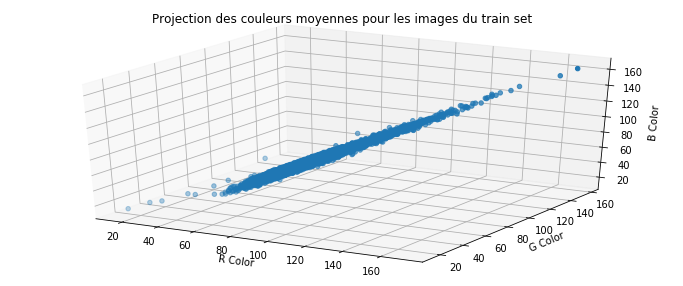

In [34]:
# on trace le nuage de points 3D
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(col_level1, col_level2, col_level3)
ax.set_title('Projection des couleurs moyennes pour les images du train set')
ax.set_xlabel('R Color')
ax.set_ylabel('G Color')
ax.set_zlabel('B Color')


A première vue, la majorité des points semblent se situer dans un plan d'équation (R = G = B), cad avec les 3 niveaux de couleur à peu près identiques. Nous pouvons le confirmer en traçant les projections 2D associées.

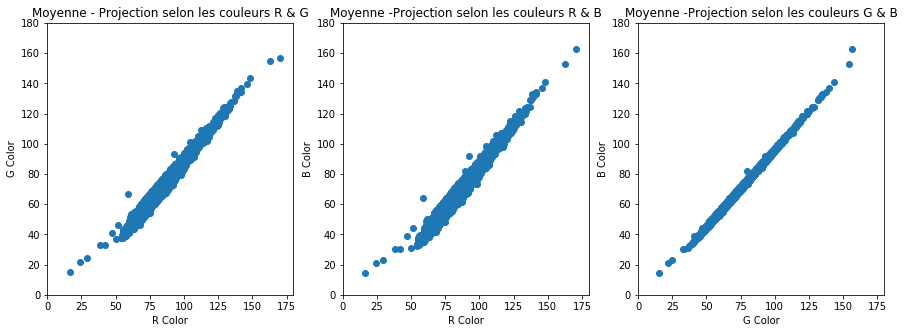

In [35]:
# on trace les nuages de points 2D pour chaque couple de variables
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(131)
ax.scatter(col_level1, col_level2)
ax.set_title('Moyenne - Projection selon les couleurs R & G')
ax.set_xlabel('R Color')
ax.set_ylabel('G Color')
ax.set_xlim([0,180])
ax.set_ylim([0,180])
ax = fig.add_subplot(132)
ax.scatter(col_level1, col_level3);
ax.set_title('Moyenne -Projection selon les couleurs R & B')
ax.set_xlabel('R Color')
ax.set_ylabel('B Color')
ax.set_xlim([0,180])
ax.set_ylim([0,180])
ax = fig.add_subplot(133)
ax.scatter(col_level2, col_level3)
ax.set_title('Moyenne -Projection selon les couleurs G & B')
ax.set_xlabel('G Color')
ax.set_ylabel('B Color')
ax.set_xlim([0,180])
ax.set_ylim([0,180])
plt.show()

Ces graphes confirment notre intuition à savoir que les points se situent très majoritairement dans le plan R = G = B.
Autrement dit, l'information sur la couleur moyenne d'une image, décrite par 3 entiers, peut facilement se résumer avec un seul. L'écart type présente les mêmes caractéristiques, ce qui semble également indiquer 
Ce résultat indique que nous devrions perdre peu d'informations en passant à une description en noir et blanc des images pour notre segmentation. Cela permettra de diviser le nombre de variables par 3! Nous constatons par ailleurs qu'il n'y a plus d'outlier.

# IV. Etude statistique des formes

Pour terminer, nous allons nous intéresser aux formes elles-mêmes. Comme pour les images, nous allons nous pencher sur leurs dimensions, et leurs couleurs. Les formes étant ici les objets que nous allons chercher à détecter nous pouvons aborder le problème de deux façons. 
- soit décrire les formes nuageuses par la localisation exacte des pixels occupés par la forme. C'est ce qui correspondra à des modèles de segmentation d'images.
- soit simplifier le problème en décrivant les formes nuageuses par un rectangle ("bounding box") contenant les pixels décrivant la forme, ce qui correspond à une approche de type détection d'objet.

Nous allons étudier les deux descriptions, même si par la suite, dans la définition et l'entraînement du modèle, nous nous concentrerons sur une approche de type "détection d'objet".


## IV.1 Etude statistique des formes exactes (pixels)


### IV.1.A Etude statistique de la taille des formes (pixels)

Nous avons vu dans la première partie la relation d'encodage de la colonne EncodedPixels. Nous pouvons donc facilement définir une fonction qui renvoit le nombre de pixels pour un couple (image,forme) donné.

In [23]:
def get_nb_pixels(pixel_string):
    # en cas d'absence de forme, on 0
    nb_pix = 0
    if str(pixel_string) == 'nan':
        return 0
    else:
        # etape 1 on redécoupe le string en array de couples correspondant aux A et B
        segment_list = np.array([int(num_string) for num_string in pixel_string.split(' ')]).reshape(-1,2)
        # etape 2: calcul du nb de pixels: la segment_list contient donc autant de lignes que de segment, 
        # et la longueur en pixels de chaque segment est donnée par sa seconde coordonnée      
        for k in range(segment_list.shape[0]):
               nb_pix += segment_list[k,1]
        return nb_pix
    

In [24]:
pixel_string = df_train.iloc[1,1]
nb = get_nb_pixels(pixel_string)

Ajoutons à présent une colonne à notre dataframe, correspondant au nombre de pixels associé à chaque couple (ImageId, Forme)

In [25]:
df_train['nb_pixels'] = df_train['EncodedPixels'].apply(lambda x: get_nb_pixels(x))
df_train.head()

,Image_Label,EncodedPixels,ImageId,Label,nb_pixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,932312
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,1156107
2,0011165.jpg_Gravel,NaN,0011165.jpg,Gravel,0
3,0011165.jpg_Sugar,NaN,0011165.jpg,Sugar,0
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,1684325


Nous sommes désormais en mesure de regarder quelques statistiques sur la taille des formes.
Nous pouvons commencer par regarder les tailles moyennes des formes (donc lorsqu'il y a une forme) indépendamment de la forme.

Nombre total de formes présentent sur le dataset entrainement: 11836
Nombre de pixels moyen par forme: 829028.0970767151


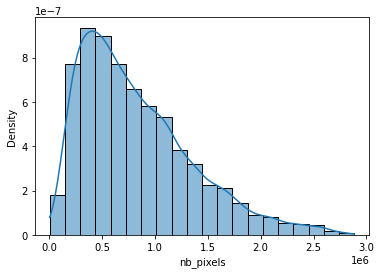

In [23]:
nb_form = df_train[df_train['nb_pixels'] != 0].shape[0]
print('Nombre total de formes présentent sur le dataset entrainement:', nb_form)
print('Nombre de pixels moyen par forme:',df_train[df_train['nb_pixels'] != 0].nb_pixels.mean() )
#sns.histplot(df_train[df_train['nb_pixels'] != 0].nb_pixels, bins=20, kde=True,stat = "density")
plt.show()


Nous pouvons également regarder ces distributions séparément pour chaque forme, en affichant un histogramme de fréquence normalisée (densité) d'apparition pour chaque forme. On constate à nouveau la domination de la forme Sugar dans les images de taille moyennes(< 1000000 pixels). Par contre, ce sont les formes Flower et Gravel qui sont les plus fréquentes au sein des images de grande taille (> 2500000 pixels).

In [26]:
df_form = df_train[(df_train['nb_pixels'] != 0)]

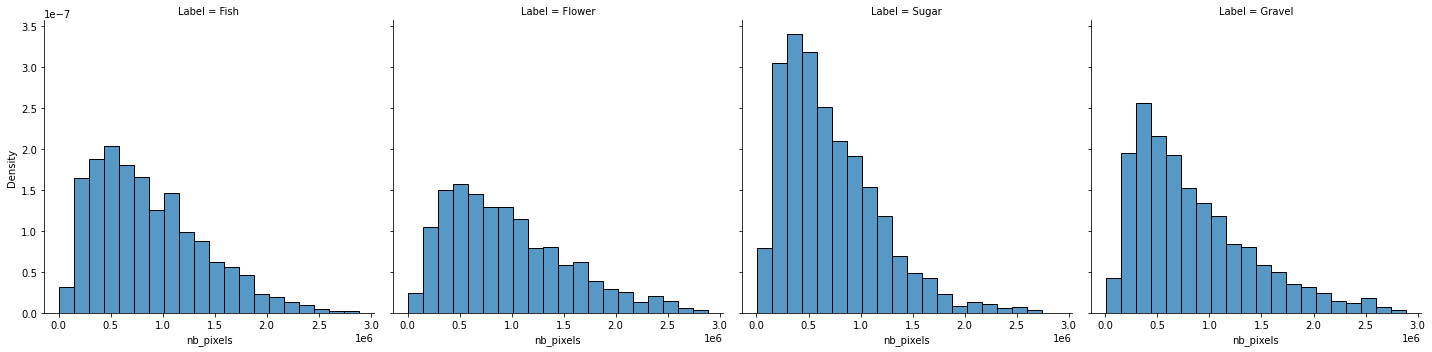

In [24]:
sns.set_context(font_scale=2)  
sns.displot(data=df_form, bins = 20, x='nb_pixels', col="Label",stat = "density")
#plt.legend(fontsize = )
plt.show()

Nous calculons également la fréquence totale de chaque Label.

In [27]:
df_form['Label'].value_counts(normalize = True)*100

Sugar     31.691450
Gravel    24.831024
Fish      23.496114
Flower    19.981413
Name: Label, dtype: float64

Nous pouvons également visualiser cette distribution du nombre de pixels selon son Label sous forme de boîte à moustaches.

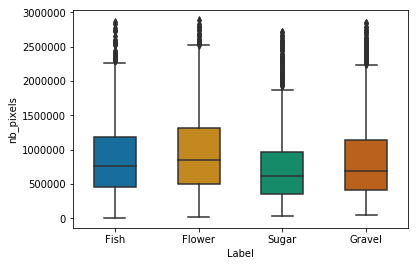

In [28]:
bplot = sns.boxplot(y='nb_pixels', x='Label', 
                 data=df_form, 
                 width=0.5,
                 palette="colorblind")

Nous pouvons finalement comparer les tailles moyennes des différentes formes.

In [29]:
df_form.groupby('Label').mean()

,nb_pixels
Label,
Fish,866464.659475
Flower,954321.082030
Gravel,838390.718952
Sugar,714939.657958


En conclusion, la forme la plus fréquente est Sugar, mais avec une taille moyenne la plus faible (715000 pixels). A contrario, Flower semble être la forme la moins fréquente mais avec la taille moyenne la plus importante (954000 pixels). Ces tailles sont à comparer à la taille totale de l'image qui est 2940000 pixels.
En terme de taille, la distribution semble être à peu près normale (éventuellement une loi de Poisson), pour chacune des 4 formes.

Nous pouvons aller plus loin en effectuant des tests de comparaison de moyenne : 

In [30]:
X1 = df_form[df_form['Label']=='Fish']["nb_pixels"]
X2 = df_form[df_form['Label']=='Gravel']["nb_pixels"]

import scipy.stats as stats
y = stats.ttest_ind(X1,X2) ; print(y)

Ttest_indResult(statistic=1.9592980532881685, pvalue=0.05012641063440876)


### IV.1.B Etude statistique des couleurs des formes (pixels)

Il s'agit de mener la même analyse que pour les images, à savoir calculer les 3 niveaux de couleurs moyens, mais cette fois-ci en se concentrant uniquement sur les pixels définissant les formes (correspondant à la colonne EncodedPixels du fichier train.csv).
Nous commençons par définir une fonction qui retourne, pour un couple image/forme, le niveau moyen, pour une couleur donnée de la zone de l'image délimitée par la forme. Du fait du temps de calcul important et de notre constat précédent, nous limiterons notre analyse à 1 seule couleur.

In [31]:
def mean(imageid, encodedpixels, color=1) : #color  = 1, 2 ou 3
    
    img_color = cv2.imread('train_images/' + imageid)
    segment_list = np.array([int(num_string) for num_string in encodedpixels.split(' ')]).reshape(-1,2)
    
    abscisses = segment_list[:,0]//1400
    ordonnee1 = segment_list[:,0]%1400

    liste_coord=[]
    for x,y,z in zip(abscisses, ordonnee1, segment_list[:,1]) :
        for i in range(z) :
                liste_coord.append((x,y+i))
    res = []
    for x in liste_coord :
        if (0<= x[1]<1400) and (0<=x[0]< 2100): 
            res.append(img_color[x[1],x[0], color-1])  
    if len(res) > 0:
        return sum(res)/len(res)
    else:
        return 0

In [32]:
def mean2(imageid, encodedpixels, color=1) : #color  = 1, 2 ou 3
    
    img_color = cv2.imread('train_images/' + imageid)
    segment_list = np.array([int(num_string) for num_string in encodedpixels.split(' ')]).reshape(-1,2)
 

    # on boucle sur les couples (A,B) de la segment_list
    res = []
    for a, b in segment_list:
            # on recalcule les coordonnées du premier point P du segment
        y = a // 1400
        x = a % 1400
        # on recupere la valeur de chaque pixel correspondant dans l'image sur tout le segment
        for j in range(b):
                if (0<=(x+j) <1400) and (0<=y < 2100): 
                    res.append(img_color[x+j,y, color-1]) 
                
    return sum(res)/len(res)

Nous allons ajouter une colonne avec la première couleur moyenne correspondante au couple image/forme. Le temps de calcul est important du fait que l'on doive récupérer une liste de pixels puis les parcourir sur l'image pour récupérer le niveau de couleur. Nous limitons donc notre analyse ici à 500 couples image/forme.

In [53]:
df2 = df_form.head(500)
import time
t0 = time.perf_counter()
df2['mean_level1'] = df2.apply(lambda x: mean(x.ImageId, x.EncodedPixels,1), axis=1)
t1 = time.perf_counter() 
print("temps d'exécution:",t1-t0)
df2.head()

temps d'exécution: 1055.3924871179997


/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Image_Label,EncodedPixels,ImageId,Label,nb_pixels,mean_level1
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,932312,73.197671
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,1156107,111.014297
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,1684325,94.258648
5,002be4f.jpg_Flower,1339279 519 1340679 519 1342079 519 1343479 51...,002be4f.jpg,Flower,592697,92.296512
7,002be4f.jpg_Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...,002be4f.jpg,Sugar,313950,67.422956


In [54]:
df2.groupby("Label").describe()

nb_pixels                                                              \
           count           mean            std       min       25%       50%   
Label                                                                          
Fish       110.0  941961.736364  552584.047189  117000.0  469805.0  888617.5   
Flower     109.0  984992.633028  517692.696609   56165.0  620059.0  898897.0   
Gravel     118.0  887475.855932  551018.062822  108779.0  424417.5  739766.0   
Sugar      163.0  696507.705521  478141.521982  115623.0  306286.0  517474.0   

                              mean_level1                                    \
               75%        max       count        mean        std        min   
Label                                                                         
Fish    1299232.75  2228403.0       110.0   97.961185  17.839752  58.761083   
Flower  1219363.00  2326817.0       109.0  100.871671  17.406826  63.033677   
Gravel  1241708.75  2372323.0       118.0   83.150006  13.282068  53.351911   
Sugar    967785.50  2223123.0       163.0   75.284884  13.416439  48.344861   

                                                       
              25%         50%         75%         max  
Label                                                  
Fish    86.843464   94.430665  106.663262  152.230735  
Flower  90.052100  100.153776  110.914825  157.384062  
Gravel  73.017482   82.310423   92.679891  114.557493  
Sugar   66.636333   73.274815   82.823987  117.041147

Nos calculs semblent cohérents, aucun niveau moyen n'est situé à l'extérieur de l'intervalle [0 ; 255]. 

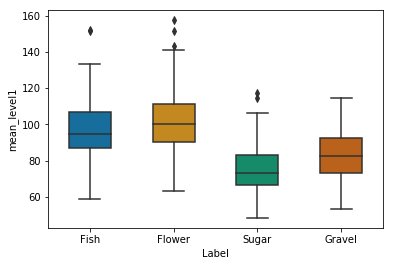

In [55]:
sns.boxplot(y='mean_level1', x='Label', 
                 data=df2, 
                 width=0.5,
                 palette="colorblind")
plt.show()

Il semble y avoir des différences significatives de niveaux de couleur moyens entre différents labels.
Différences à confirmer par des tests de Student 2 à 2 :


In [56]:
X1 = df2[df2['Label']=='Fish']["mean_level1"]
X2 = df2[df2['Label']=='Gravel']["mean_level1"]

import scipy.stats as stats
y = stats.ttest_ind(X1,X2) ; print(y)

Ttest_indResult(statistic=7.142200989666467, pvalue=1.2469226600029048e-11)


#### Interprétation des résultats:

Ces niveaux de couleur moyens constatés sont assez cohérents avec les premières visualisation d'images que nous avons effectué. Pour comprendre cela, visualisons quelques formes. Nous aurons besoin d'une fonction qui nous partant d'une image et du masque correspondant, nous renvoie l'image avec uniquement les pixels "allumés" sur la zone définie par le masque.

In [33]:
def filter_on_mask(img, mask):
    rows = 1400
    cols = 2100
    filtered_img = np.zeros((rows,cols,3))
    for k in range(rows):
        for l in range(cols):
            if mask[k,l] == 255:
                #print("pixel!")
                pix = img[k,l,:]
                #print(pix)
                filtered_img[k,l,:] = pix/255
    return filtered_img

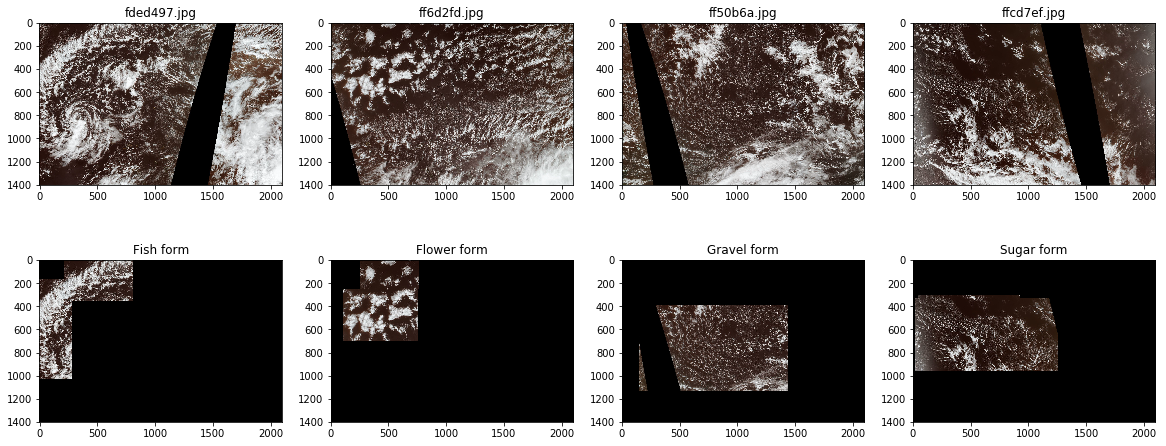

In [34]:
#df_form[df_form['Label']=='Sugar'].tail(20)
# Visualisation d'un fish
img_name1 = 'fded497.jpg'
img_path1 = "train_images/" + img_name1
img_color1= cv2.imread(img_path1,cv2.COLOR_BGR2RGB)
#img_color2=cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
# masque pour la forme Fish
encoded_fish = df_form[(df_form['ImageId'] == img_name1) & (df_form['Label'] == 'Fish') ].iloc[0,1]
mask_fish = pixels_to_img(encoded_fish, 1400, 2100 )
filtered_fish = filter_on_mask(img_color1, mask_fish)

# Visualisation d'un flower
img_name2 = 'ff6d2fd.jpg'
img_path2 = "train_images/" + img_name2
img_color2= cv2.imread(img_path2,cv2.COLOR_BGR2RGB)
# masque pour la forme Flower
encoded_flower = df_form[(df_form['ImageId'] == img_name2) & (df_form['Label'] == 'Flower') ].iloc[0,1]
mask_flower = pixels_to_img(encoded_flower, 1400, 2100 )
filtered_flower = filter_on_mask(img_color2, mask_flower)

# Visualisation d'un gravel
img_name3 = 'ff50b6a.jpg'
img_path3 = "train_images/" + img_name3
img_color3= cv2.imread(img_path3,cv2.COLOR_BGR2RGB)
# masque pour la forme Gravel
encoded_gravel = df_form[(df_form['ImageId'] == img_name3) & (df_form['Label'] == 'Gravel') ].iloc[0,1]
mask_gravel = pixels_to_img(encoded_gravel, 1400, 2100 )
filtered_gravel = filter_on_mask(img_color3, mask_gravel)

# Visualisation d'un sugar
img_name4 = 'ffcd7ef.jpg'
img_path4 = "train_images/" + img_name4
img_color4= cv2.imread(img_path4,cv2.COLOR_BGR2RGB)
# masque pour la forme sugar
encoded_sugar = df_form[(df_form['ImageId'] == img_name4) & (df_form['Label'] == 'Sugar') ].iloc[0,1]
mask_sugar = pixels_to_img(encoded_sugar, 1400, 2100 )
filtered_sugar = filter_on_mask(img_color4, mask_sugar)

plt.figure(figsize = (20,8))
plt.subplot(2,4,1)
plt.imshow(img_color1, cmap='gray', interpolation='nearest')
plt.title(img_name1)
plt.subplot(2,4,2)
plt.imshow(img_color2, cmap='gray', interpolation='nearest')
plt.title(img_name2)
plt.subplot(2,4,3)
plt.imshow(img_color3, cmap='gray', interpolation='nearest')
plt.title(img_name3)
plt.subplot(2,4,4)
plt.imshow(img_color4, cmap='gray', interpolation='nearest')
plt.title(img_name4)

plt.subplot(2,4,5)
plt.imshow(filtered_fish, cmap='gray', interpolation='nearest')
plt.title('Fish form')
plt.subplot(2,4,6)
plt.imshow(filtered_flower, cmap='gray', interpolation='nearest')
plt.title('Flower form')
plt.subplot(2,4,7)
plt.imshow(filtered_gravel, cmap='gray', interpolation='nearest')
plt.title('Gravel form')
plt.subplot(2,4,8)
plt.imshow(filtered_sugar, cmap='gray', interpolation='nearest')
plt.title('Sugar form')
plt.show()

Interprétation: en visualisant quelques images, nous comprenons mieux les différences de niveaux de couleurs. En effet nous voyons que:
- Fish et Flower sont assez lumineux, du fait de la présence de gros nuages allongé (Fish) ou de nombreux nuages de taille moyenne (Flower)
- en revanche gravel et sugar sont moins lumineux du fait de la petite taille de nuages éparpillés (gravel) ou même de l'absence complète de nuage, donc de zones noires (Sugar)

### IV.1.C Identification d'outliers via l'encodedpixels


Dans la méthode qui nous renvoie les pixels exacts correspondant à la colonne encodedpixels, nous avons filtré sur les coordonnées des pixels calculés, de manière à ne retenir que ceux qui seraient présents dans l'image. Une autre étude que nous avons mené en parallèle est d'identifier les images dont l'encodedpixel serait incohérent, c'est-à-dire qui renverraient des coordonnées de point en dehors de l'image. C'est l'objet de cette section.

In [35]:
def resolv(encodedpixels) : # retourne la hauteur que peuvent prendre les pixels d'une forme
    segment_list = np.array([int(num_string) for num_string in encodedpixels.split(' ')]).reshape(-1,2)
    hauteur_min = segment_list[:,0]%1400
    hauteur_max = (hauteur_min + segment_list[:,1]).max()
    return hauteur_max
    

La fonction ci-dessus, pour une forme donnée, retourne la valeur maximale que peut prendre la "hauteur" d'une ligne verticale de pixels liés à une forme. Les images ayant toute pour dimension (1400,2100), les valeurs supérieures à 1400 correspondront à des observations qui posent problème.
Appliquons donc cette fonction à notre dataset :

In [87]:
df3=df_train.dropna()
df3['dims']=df3['EncodedPixels'].apply(lambda x : resolv(x))

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [88]:
df3[df3.dims > 1400].shape

(22, 6)

22 observations sont problématiques. Ci-dessous, on s'aperçoit que l'encodage de la forme lié à la première observation défectueuse de notre dataset est effectivement incompréhensible, on s'en aperçoit à la lecture des premiers membres de la liste :

In [89]:
encodederror=df3[df3.dims > 1400].iloc[0,1]

In [90]:
encodederror[:200]

'1748601 886201 2634803 1406 2636210 1391 2637609 8 2637619 1382 2639005 1 2639008 1 2639011 6 2639020 1397 2640419 4 2640428 1373 2641809 4 2641830 1371 2643209 1392 2644609 1392 2646009 1392 2647409 '

In [92]:
df3=df3[df3.dims < 1401]

df3 correspond à notre dataset auquel on a retiré ces 22 observations.

In [93]:
#df3['mean_level1'] = df3.apply(lambda x: mean(x.ImageId, x.EncodedPixels), axis=1)

## IV.2 Définition et étude statistique de bounding boxes

Dans la construction de notre modèle de prédiction des zones, nous allons simplifier notre problème à la recherche d'un rectangle, ou bounding box, contenant la zone d'intéret. C'est la méthode classique de détection d'objet, et cela permet de ramener le problème à la régression de 4 variables, décrivant la bounding box:
- soit les coordonnées de 2 points opposés du rectangle (xmin, xmax, ymi,n, ymax)
- soit les coordonnées du centre de rectangle (X,Y), sa largeur w, sa hauteur h

Dans cette section, nous allons faire un premier calcul de bounding box, afin de pouvoir mener quelques études statistiques dessus. Puis nous afinerons notre définition.


### IV.2.A Première définition et analyse de Bounding Box

Une première façon de calculer les bounding box est de simplement déduire du masque correspondant à la forme, les 2 points (xmin,ymin) et (xmax, ymax) encadrant la zone définie par encodedpixels. En somme, nous calculons la plus petite bounding box contenant l'ensemble des pixels de la forme.

In [36]:
def pixels_to_dim(pixel_string, hauteur, largeur ):
    # dans le doute on passe en argument les dimensions de l'image à créer
    rows, cols = hauteur, largeur 
    hmin = hauteur
    hmax = 0
    lmin = largeur
    lmax = 0
    
    # en cas d'absence de forme, on renvoit uniquement un tableau de 0
    if str(pixel_string) == 'nan':
        return [-9999,9999,-9999,9999]
    else:
        # etape 1 on redécoupe le string en array de couples correspondant aux A et B ci dessus
        segment_list = np.array([int(num_string) for num_string in pixel_string.split(' ')]).reshape(-1,2)
        
        # etape 2: on initialise un vecteur de dimension totale (hauteur x largeur)
        #img = np.zeros((rows,cols))
        # on boucle sur les couples (A,B) de la segment_list
        for a, b in segment_list:
            # premierement, on va chercher les points avec les largeurs extrêmes
            # on recalcule les coordonnées du premier point P du segment
            y = a // hauteur
            x = a % hauteur
            # on met à 255 la valeur de tous les pixels du segment correspondant
            # on checke que le point estimé est bien sur l'image
            if (0<=(x+b) <= hauteur) and (0<=y <= largeur): 
                    #si oui on ajuste nos dimensions min et max en fonction
                if x <= hmin:
                    hmin = x
                if (x+b) >= hmax: 
                    hmax = x+b
                if y <= lmin:
                    lmin = y
                if y >= lmax:
                    lmax = y                  
        return [hmin, hmax, lmin, lmax]

In [102]:
df_form['bbox'] = df_form['EncodedPixels'].apply(lambda x: pixels_to_dim(x,1400,2100))
df_form.head()

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Image_Label,EncodedPixels,ImageId,Label,nb_pixels,bbox
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,932312,"[318, 1255, 189, 1183]"
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,1156107,"[314, 1367, 968, 2094]"
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,1684325,"[10, 891, 167, 2086]"
5,002be4f.jpg_Flower,1339279 519 1340679 519 1342079 519 1343479 51...,002be4f.jpg,Flower,592697,"[879, 1398, 956, 2097]"
7,002be4f.jpg_Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...,002be4f.jpg,Sugar,313950,"[295, 645, 48, 944]"


Nous nettoyons ce premier dataframe, afin de le sauvegarder.

In [103]:
df_form['h_min'] = df_form['bbox'].apply(lambda x: x[0])
df_form['h_max'] = df_form['bbox'].apply(lambda x: x[1])
df_form['l_min'] = df_form['bbox'].apply(lambda x: x[2])
df_form['l_max'] = df_form['bbox'].apply(lambda x: x[3])
df_form.head()

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

,Image_Label,EncodedPixels,ImageId,Label,nb_pixels,bbox,h_min,h_max,l_min,l_max
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,932312,"[318, 1255, 189, 1183]",318,1255,189,1183
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,1156107,"[314, 1367, 968, 2094]",314,1367,968,2094
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,1684325,"[10, 891, 167, 2086]",10,891,167,2086
5,002be4f.jpg_Flower,1339279 519 1340679 519 1342079 519 1343479 51...,002be4f.jpg,Flower,592697,"[879, 1398, 956, 2097]",879,1398,956,2097
7,002be4f.jpg_Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...,002be4f.jpg,Sugar,313950,"[295, 645, 48, 944]",295,645,48,944


In [106]:
df_form.shape
df_form.to_csv('train_with_bbox_V0_finalversion.csv')

 Puis nous pouvons étudier les distributions des différentes coordonnées de ces bounding boxes. Pour cela nous allons d'abord les remettre au format plus parlant à savoir (X,Y,w,h).

In [108]:
larg = 2100
haut = 1400
df_form['xmoy'] = (df_form.l_max + df_form.l_min)/2/larg
df_form['ymoy'] = (df_form.h_max + df_form.h_min)/2/haut
df_form['w'] = (df_form.l_max - df_form.l_min)/larg
df_form['h'] = (df_form.h_max - df_form.h_min)/haut

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

/anaconda/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


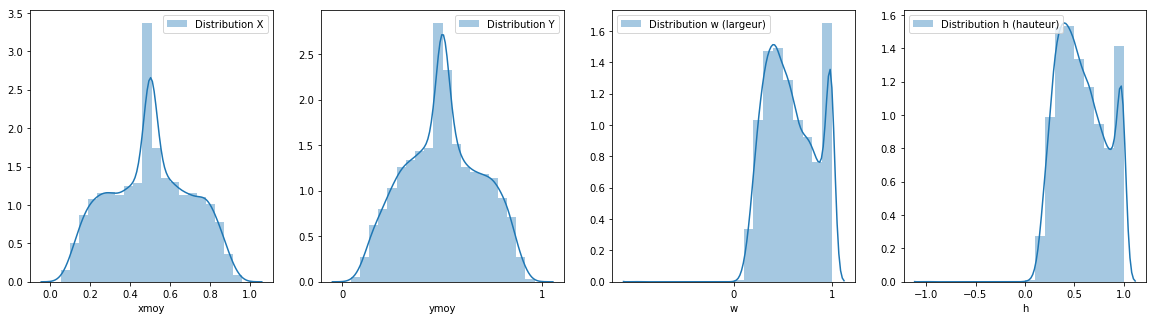

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (20,5))
plt.xticks([0.0,1])
plt.subplot(1,4,1)
sns.distplot(df_form.xmoy, bins = 20, label = 'Distribution X')
plt.legend()
plt.subplot(1,4,2)
sns.distplot(df_form.ymoy, bins = 20, label = 'Distribution Y')
plt.xticks([0.0,1])
plt.legend()
plt.subplot(1,4,3)
sns.distplot(df_form.w, bins = 20, label = 'Distribution w (largeur)')
plt.xticks([0.0,1])
plt.legend()
plt.subplot(1,4,4)
sns.distplot(df_form.h, bins = 20, label = 'Distribution h (hauteur)')
plt.legend(loc = 'upper left')
plt.show()

Ces graphes soulignent la faiblesse de cette première approche: on constate qu'il y a un nombre important de couple image/forme dont la largeur et la hauteur de la bounding box délimitant la forme sont proches de celles de l'image. Autrement dit, la bounding box recouvre entirement l'image. Logiquement ce pic de densité en largeur et hauteur correspond à un pic de densité au centre de l'image pour les coordonnées du centre de la bounding box.
Il y a une explication simple à ce phénomène: nous avons constaté que pour certaines images, la zone exacte associée à une forme pouvait être la réunion de plusieurs zones réparties sur l'image. En prenant la bounding box qui contient toutes ces zones, on a tendance à définir des bounding boxes trop grandes (l'exemple extrême étant de prendre un pixel dans le coin en bas à gauche, et un pixel dans le coin en haut à droite: la bounding box extrapolée correspond à la totalité des pixels de l'image, alors qu'en réalité il n'y avait que 2 pixels pour définir la forme).

Ces résultats nous ont motivé à affiner notre définition des bounding boxes, et c'est l'objet de la section suivante.

### IV.2.B Définition plus fine des bounding boxes

Dans cette deuxième définition de bounding box, nous souhaitons éviter de définir des bounding boxes trop grandes. Pour cela, nous allons nous appuyer sur la librairie OpenCV, et sa méthode findContours. En effet, OpenCV permet à partir d'un masque (ie un ensemble de pixels allumés ou éteint) de repérer les différentes zones présentes sur le masque, et de calculer une bounding box pour chacune des zones.
Ici, nous avons fait le choix de ne garder pour chaque couple/image que la plus grande des bounding boxes identifiées. C'est ce que fait la fonction get_rectangle:

In [37]:
def get_rectangle(mask):
    image = np.array(mask, dtype = np.uint8)
    ret, thresh = cv2.threshold(image,0, 255, 0)
    contours, hierarchy= cv2.findContours(thresh,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    area_list = []
    for k in range(len(contours)):
        cnt = contours[k]
        area = cv2.contourArea(cnt)
        area_list.append(area)
    hmin,hmax,lmin,lmax = 0,0,0,0
    if len(area_list):
        max_value = max(area_list)
        max_index = area_list.index(max_value)
        x,y,w,h = cv2.boundingRect(contours[max_index])
        hmin= y 
        hmax = y + h
        lmin = x
        lmax = x + w
    return hmin,hmax,lmin,lmax

def get_dim_max(img):
    rows = 1400
    cols = 2100
    hmin = rows
    hmax = 0
    lmin = cols
    lmax = 0    
    for k in range(rows):
        for l in range(cols):
            if img[k,l] == 255:
                if k < hmin:
                    hmin = k
                if k > hmax:
                    hmax = k
                if l < lmin:
                    lmin = l 
                if l > lmax:
                    lmax = l
    return hmin, hmax, lmin, lmax

def img_to_bbox(img):
    rows = 1400
    cols = 2100
    bbox_img = np.zeros((rows,cols))
    # find the dimensions of the bbox
    hmin, hmax, lmin, lmax = get_dim_max(img)
    # turn pixel on for the corresponding zone
    for k in range(rows):
        for l in range(cols):
            if hmin <= k <= hmax and lmin <= l <= lmax:
                bbox_img[k,l] = 255
    #print(type(bbox_img))
    return bbox_img

Définissons également une méthode permettant de calculer le masque correspondant à une bounding box.

In [38]:
def rect_to_bbox(hmin,hmax,lmin,lmax):
    rows = 1400
    cols = 2100
    bbox_img = np.zeros((rows,cols))
    # find the dimensions of the bbox
    # turn pixel on for the corresponding zone
    for k in range(rows):
        for l in range(cols):
            if hmin <= k <= hmax and lmin <= l <= lmax:
                bbox_img[k,l] = 255
    #print(type(bbox_img))
    return bbox_img

Afin de bien comprendre la différence de résultat attendu, testons la sur une image contenant plusieurs formes.

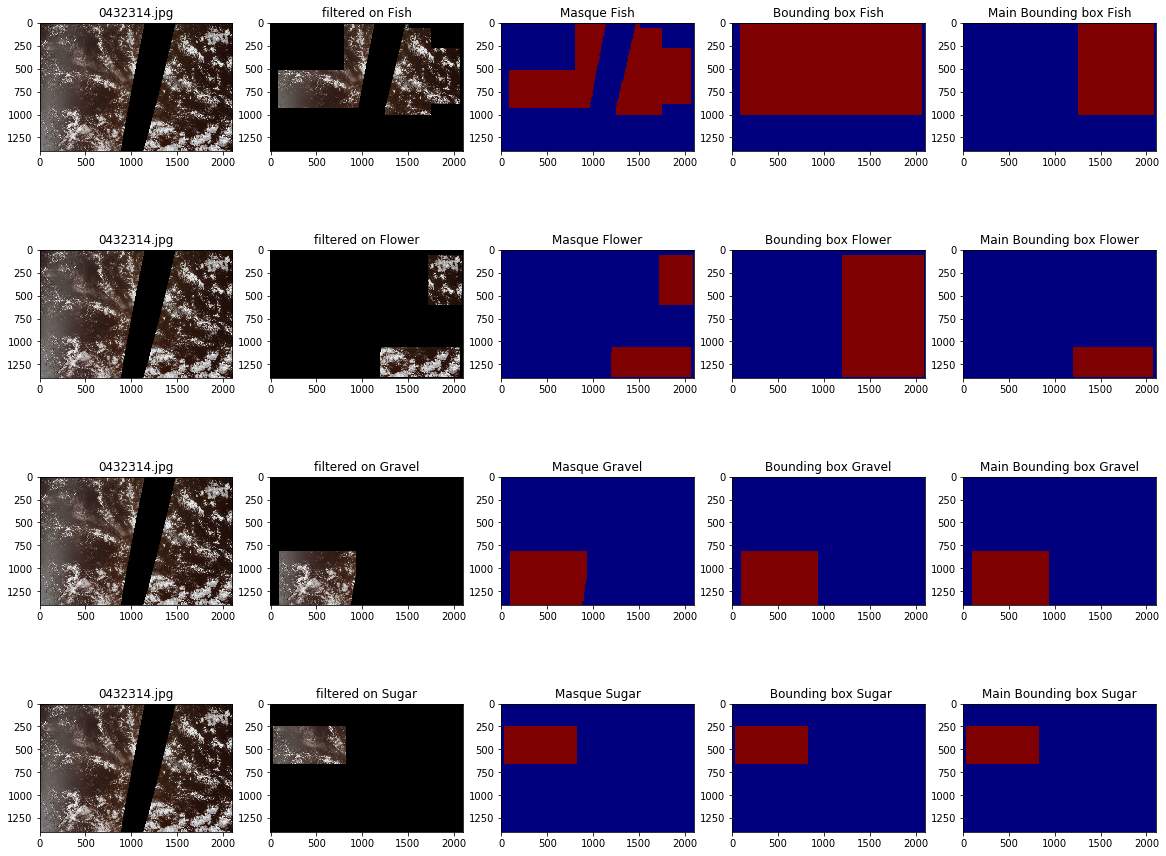

In [39]:
img_name = '0432314.jpg'
img_path = "train_images/" + img_name

img_color= cv2.imread(img_path,cv2.COLOR_BGR2RGB)
img_color2=cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
# masque pour la forme Fish
encoded_fish = df_train[(df_train['ImageId'] == img_name) & (df_train['Label'] == 'Fish') ].iloc[0,1]
#print(type(encoded_fish))
mask_fish = pixels_to_img(encoded_fish, 1400, 2100 )
filtered_fish = filter_on_mask(img_color, mask_fish)
bbox_fish = img_to_bbox(mask_fish)
x,y,w,h = get_rectangle(mask_fish)
main_bbox_fish = rect_to_bbox(x,y,w,h)

# masque pour la forme Flower
encoded_flower = df_train[(df_train['ImageId'] == img_name) & (df_train['Label'] == 'Flower') ].iloc[0,1]
mask_flower = pixels_to_img(encoded_flower, 1400, 2100 )
filtered_flower = filter_on_mask(img_color, mask_flower)
#filtered_fish = cv2.imread(filtered_img, cv2.COLOR_BGR2RGB)
bbox_flower = img_to_bbox(mask_flower)
x,y,w,h = get_rectangle(mask_flower)
main_bbox_flower = rect_to_bbox(x,y,w,h)

# masque pour la forme Gravel
encoded_gravel = df_train[(df_train['ImageId'] == img_name) & (df_train['Label'] == 'Gravel') ].iloc[0,1]
mask_gravel = pixels_to_img(encoded_gravel, 1400, 2100 )
filtered_gravel = filter_on_mask(img_color, mask_gravel)
#filtered_fish = cv2.imread(filtered_img, cv2.COLOR_BGR2RGB)
bbox_gravel = img_to_bbox(mask_gravel)
x,y,w,h = get_rectangle(mask_gravel)
main_bbox_gravel = rect_to_bbox(x,y,w,h)

# masque pour la forme Sugar
encoded_sugar = df_train[(df_train['ImageId'] == img_name) & (df_train['Label'] == 'Sugar') ].iloc[0,1]
mask_sugar = pixels_to_img(encoded_sugar, 1400, 2100 )
filtered_sugar = filter_on_mask(img_color, mask_sugar)
#filtered_fish = cv2.imread(filtered_img, cv2.COLOR_BGR2RGB)
bbox_sugar = img_to_bbox(mask_sugar)
x,y,w,h = get_rectangle(mask_sugar)
main_bbox_sugar = rect_to_bbox(x,y,w,h)


plt.figure(figsize = (20,16))

plt.subplot(4,5,1)
plt.imshow(img_color, cmap='gray', interpolation='nearest')
plt.title(img_name)
plt.subplot(4,5,2)
plt.imshow(filtered_fish, cmap='gray', interpolation='nearest')
plt.title('filtered on Fish')
plt.subplot(4,5,3)
plt.imshow(mask_fish, cmap='jet', interpolation='nearest')
plt.title('Masque Fish')
plt.subplot(4,5,4)
plt.imshow(bbox_fish, cmap='jet', interpolation='nearest')
plt.title('Bounding box Fish')
plt.subplot(4,5,5)
plt.imshow(main_bbox_fish, cmap='jet', interpolation='nearest')
plt.title('Main Bounding box Fish')

plt.subplot(4,5,6)
plt.imshow(img_color, cmap='gray', interpolation='nearest')
plt.title(img_name)
plt.subplot(4,5,7)
plt.imshow(filtered_flower, cmap='gray', interpolation='nearest')
plt.title('filtered on Flower')
plt.subplot(4,5,8)
plt.imshow(mask_flower, cmap='jet', interpolation='nearest')
plt.title('Masque Flower')
plt.subplot(4,5,9)
plt.imshow(bbox_flower, cmap='jet', interpolation='nearest')
plt.title('Bounding box Flower')
plt.subplot(4,5,10)
plt.imshow(main_bbox_flower, cmap='jet', interpolation='nearest')
plt.title('Main Bounding box Flower')

plt.subplot(4,5,11)
plt.imshow(img_color, cmap='gray', interpolation='nearest')
plt.title(img_name)
plt.subplot(4,5,12)
plt.imshow(filtered_gravel, cmap='gray', interpolation='nearest')
plt.title('filtered on Gravel')
plt.subplot(4,5,13)
plt.imshow(mask_gravel, cmap='jet', interpolation='nearest')
plt.title('Masque Gravel')
plt.subplot(4,5,14)
plt.imshow(bbox_gravel, cmap='jet', interpolation='nearest')
plt.title('Bounding box Gravel')
plt.subplot(4,5,15)
plt.imshow(main_bbox_gravel, cmap='jet', interpolation='nearest')
plt.title('Main Bounding box Gravel')

plt.subplot(4,5,16)
plt.imshow(img_color, cmap='gray', interpolation='nearest')
plt.title(img_name)
plt.subplot(4,5,17)
plt.imshow(filtered_sugar, cmap='gray', interpolation='nearest')
plt.title('filtered on Sugar')
plt.subplot(4,5,18)
plt.imshow(mask_sugar, cmap='jet', interpolation='nearest')
plt.title('Masque Sugar')
plt.subplot(4,5,19)
plt.imshow(bbox_sugar, cmap='jet', interpolation='nearest')
plt.title(' Bounding box Sugar')
plt.subplot(4,5,20)
plt.imshow(main_bbox_sugar, cmap='jet', interpolation='nearest')
plt.title('Main Bounding box Sugar')


plt.show()

Nous avons volontairement pris une image contenant les 4 formes. Sur ce graphique pour cette même image (colonne 1) et pour chacune des formes (lignes 1 à 4) qu'elle contient, nous avons affiché le masque exact (colonne 2 et 3) tel que calculé à partir de l'EncodedPixels, ainsi que la version précédente de Bounding Box (colonne 4) et notre nouvelle version (colonne 5) qui se limite à la bounding box de la plus grosse des zones identifiées sur l'image. On voit notamment que pour les formes Fish et Flower, la bounding box obtenue est bien plus petite qu'avec la méthode précédente.
On voit également que pour certaines formes, les 2 méthodes donnent le même résultat (Gravel, Sugar).



#### Définition "mixte" de bounding boxes et préprocessing de nos données

Quelques tests de performance non présentées ici montrent également que le calcul de la bounding box avec la seconde méthode est entre 100 et 700 fois plus long qu'avec la première méthode (du fait de la recherche des contours, et de la sélection du contours correspondant à l'aire la plus grande). 

Partant de ce constat, et pour éviter un temps de calcul trop long, nous avons décidé de préprocesser nos données avec une méthode intermédiaire qui est la suivante:
- on repart de notre premier calcul de bounding box et on en déduit l'aire correspondante.
- on calcule le ratio nb_pixels/aire_bbox.
- lorsque ce ratio est trop petit (<0.9) cela signifie que notre extrapolation basique en bounding box a été trop forte. Dans ce cas on recalcule une bounding box à partir de la deuxième méthode.



In [141]:
def bbox_area(bbox) :
    return ((bbox[1]-bbox[0]+1)*(bbox[3]-bbox[2]+1))

df_form['biggest_bbox_area'] = df_form.apply(lambda x : bbox_area(x.bbox),1)

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [146]:
df_form['ratio_encod_per_rect'] = df_form['nb_pixels']/df_form['biggest_bbox_area']
df_form = df_form[df_form['ratio_encod_per_rect'] <= 1]


In [150]:
# pour tester ici nous n'executons que sur 50 lignes, le calcul exact a tourné plusieurs heures
df_test = df_form.head(50)

def final_get_rect(encod, ratio, thresh = 0.9) :
    '''
    methode qui ne recalcule la bounding box avec la deuxieme methode
    que si le ratio passé en input est superieur au seuil
    et sinon renvoie une bbox nulle
    '''
    if ratio < thresh :
        return (get_rectangle(pixels_to_img(encod, 1400, 2100)))
    else :
        return [0,0,0,0]

def choose_bbox(raw) :
    '''
    methode qui prend la bbox calculée avec la deuxieme methode (contour_bbox) quand elle a été calculée
    et sinon prend la bbo calculée avec la premiere methode (bbox)
    '''
    if raw['contour_bbox'] == [0,0,0,0] :
        return raw['bbox']
    else : 
        return raw['contour_bbox']

    
df_test['contour_bbox'] = df_test.apply(lambda x : final_get_rect(x.EncodedPixels,x.ratio_encod_per_rect,0.9), 1)
df_test['final_bbox'] = df_test.apply(choose_bbox, 1)
df_test.head(3)
#d'autres étapes ont suivi permettant de supprimer les colonnes inutiles
# et de conserver uniquement les 4 colonnes des coordonnées calculées
# elles ne sont pas mentionnées ici

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Image_Label,EncodedPixels,ImageId,Label,nb_pixels,bbox,h_min,h_max,l_min,l_max,xmoy,ymoy,w,h,biggest_bbox_area,ratio_encod_per_rect,contour_bbox,final_bbox
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,932312,"[318, 1255, 189, 1183]",318,1255,189,1183,0.326667,0.561786,0.473333,0.669286,933310,0.998931,"[0, 0, 0, 0]","[318, 1255, 189, 1183]"
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,1156107,"[314, 1367, 968, 2094]",314,1367,968,2094,0.729048,0.600357,0.536190,0.752143,1187858,0.973270,"[0, 0, 0, 0]","[314, 1367, 968, 2094]"
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,1684325,"[10, 891, 167, 2086]",10,891,167,2086,0.536429,0.321786,0.913810,0.629286,1693440,0.994617,"[0, 0, 0, 0]","[10, 891, 167, 2086]"
5,002be4f.jpg_Flower,1339279 519 1340679 519 1342079 519 1343479 51...,002be4f.jpg,Flower,592697,"[879, 1398, 956, 2097]",879,1398,956,2097,0.726905,0.813214,0.543333,0.370714,593840,0.998075,"[0, 0, 0, 0]","[879, 1398, 956, 2097]"
7,002be4f.jpg_Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...,002be4f.jpg,Sugar,313950,"[295, 645, 48, 944]",295,645,48,944,0.236190,0.335714,0.426667,0.250000,314847,0.997151,"[0, 0, 0, 0]","[295, 645, 48, 944]"
8,0031ae9.jpg_Fish,3510 690 4910 690 6310 690 7710 690 9110 690 1...,0031ae9.jpg,Fish,1240822,"[710, 1400, 2, 1819]",710,1400,2,1819,0.433571,0.753571,0.865238,0.492857,1256238,0.987728,"[0, 0, 0, 0]","[710, 1400, 2, 1819]"
9,0031ae9.jpg_Flower,2047 703 3447 703 4847 703 6247 703 7647 703 9...,0031ae9.jpg,Flower,1178858,"[501, 1350, 1, 1485]",501,1350,1,1485,0.353810,0.661071,0.706667,0.606429,1262250,0.933934,"[0, 0, 0, 0]","[501, 1350, 1, 1485]"
11,0031ae9.jpg_Sugar,658170 388 659570 388 660970 388 662370 388 66...,0031ae9.jpg,Sugar,306908,"[170, 558, 470, 1260]",170,558,470,1260,0.411905,0.260000,0.376190,0.277143,307699,0.997429,"[0, 0, 0, 0]","[170, 558, 470, 1260]"
13,0035239.jpg_Flower,100812 462 102212 462 103612 462 105012 462 10...,0035239.jpg,Flower,655989,"[12, 734, 72, 1008]",12,734,72,1008,0.257143,0.266429,0.445714,0.515714,677451,0.968319,"[0, 0, 0, 0]","[12, 734, 72, 1008]"
14,0035239.jpg_Gravel,65400 380 66800 380 68200 380 69600 380 71000 ...,0035239.jpg,Gravel,289939,"[1000, 1380, 46, 808]",1000,1380,46,808,0.203333,0.850000,0.362857,0.271429,290703,0.997372,"[0, 0, 0, 0]","[1000, 1380, 46, 808]"


### IV.2.C Analyse statistique des bounding boes (deuxième version)


Comme le calcul précédent a tourné plusieurs heures, nous l'avons exporter sous forme de fichier csv. Nous allons le loader ici pour faire son analyse statistique.


In [151]:
df = pd.read_csv('train_with_bbox_finalversion.csv')
df.head()

,Unnamed: 0,ImageId,Label,xmin,ymin,xmax,ymax
0,0,0011165.jpg,Fish,189,318,1183,1255
1,1,0011165.jpg,Flower,968,314,2094,1367
2,2,002be4f.jpg,Fish,167,10,2086,891
3,3,002be4f.jpg,Flower,956,879,2097,1398
4,4,002be4f.jpg,Sugar,48,295,944,645


Nous recalculons les coordonnées X,Y, w et h.

In [154]:
df['X'] = 0.5 * (df['xmin'] + df['xmax'])
df['Y'] = 0.5 * (df['ymin'] + df['ymax'])
df['w'] = (df['xmax'] - df['xmin'])
df['h'] = (df['ymax'] - df['ymin'])

Nous pouvons tracer les distributions correspondantes comme précédemment.

/anaconda/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


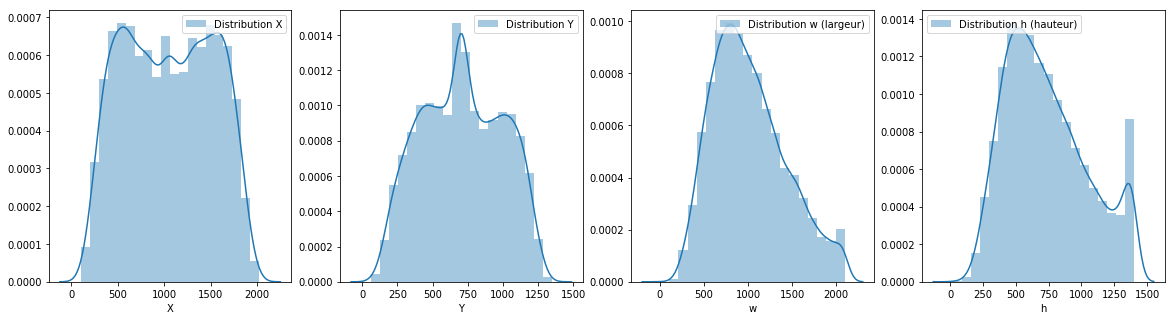

In [157]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (20,5))
plt.subplot(1,4,1)
sns.distplot(df.X, bins = 20, label = 'Distribution X')
plt.legend()
plt.subplot(1,4,2)
sns.distplot(df.Y, bins = 20, label = 'Distribution Y')
plt.legend()
plt.subplot(1,4,3)
sns.distplot(df.w, bins = 20, label = 'Distribution w (largeur)')
plt.legend()
plt.subplot(1,4,4)
sns.distplot(df.h, bins = 20, label = 'Distribution h (hauteur)')
plt.legend(loc = 'upper left')
plt.show()

On constate une amélioration de nos distributions. Néanmoins, nous voyons qu'il y a toujours un problème sur la hauteur, il reste une proportion importante de formes avec la hauteur maximale, ce qui est assez surprenant. Nous n'avons pas eu le temps d'aller plus loin dans cette analyse.